In [1]:
import jax
#import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad, jacobian
from tqdm import tqdm
from src.helpers import *

Bad value in file 'matplotlibrc', line 55 ("axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])"): Key axes.prop_cycle: "cycler('color', ['" is not a valid cycler construction: unterminated string literal (detected at line 1) (<unknown>, line 1)


### 2 times IWP

In [2]:
A = lambda h: np.array([[1, h, h**2/2], [0, 1, h], [0, 0, 1]])
Q = lambda h: np.array([[h**5/20, h**4/8, h**3/6], [h**4/8, h**3/3, h**2/2], [h**3/6, h**2/2, h]])

In [3]:
#function that samples q-times IWP path
def sample_IWP_path(q, N, h, y0=None):

    mu_0 = np.zeros(q)
    Sigma_0 = np.eye(q)
    if y0 != None:
        mu_0[0] = y0
        Sigma_0[0,0] = 0
    x = np.zeros((N, q))
    x_0 = np.random.multivariate_normal(mu_0, Sigma_0)
    x[0,:] = x_0

    for i in range(1, N):
        x[i,:] = np.random.multivariate_normal(A(h)@x[i-1,:], Q(h))
    return x



#function that samples q-times IWP path
def sample_IWP_path_from_taylor_modes(q, N, h, x_0):

    x = np.zeros((N, q))
    x[0,:] = x_0

    for i in range(1, N):
        x[i,:] = np.random.multivariate_normal(A(h)@x[i-1,:], Q(h))
    return x


In [4]:
np.random.seed(42)

t0, t1 = 0.0, 10.0
N = 222
ts = np.linspace(t0, t1, num=N, endpoint=True)
h = (t1 - t0) / N

#x1 = sample_IWP_path(3, N, h)
#x2 = sample_IWP_path(3, N, h)
#x3 = sample_IWP_path(3, N, h)
#x4 = sample_IWP_path(3, N, h)
#x5 = sample_IWP_path(3, N, h)

x1 = sample_IWP_path(3, N, h, y0=-3)
x2 = sample_IWP_path(3, N, h, y0=-3)
x3 = sample_IWP_path(3, N, h, y0=-3)
x4 = sample_IWP_path(3, N, h, y0=-3)
x5 = sample_IWP_path(3, N, h, y0=-3)

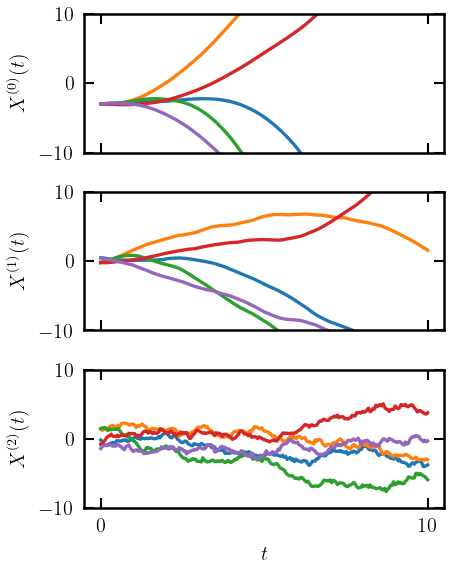

In [5]:
# Create a 3x1 subplot for each component of x
fig, axs = plt.subplots(3, 1, figsize=(4, 5))

# Plot each component of x
for i in range(3):
    axs[i].plot(ts, x1[:, i])
    axs[i].plot(ts, x2[:, i])
    axs[i].plot(ts, x3[:, i])
    axs[i].plot(ts, x4[:, i])
    axs[i].plot(ts, x5[:, i])
    if i == 2:
        axs[i].set_xlabel('$t$')
        axs[i].set_xticks([0, 10])
    if i < 2:
        axs[i].set_xticks([0, 10])
        axs[i].set_xticklabels([])
    axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
    axs[i].set_ylim(-10, 10)
    axs[i].set_yticks([-10, 0, 10])

#plt.savefig('2-times-IWP.png')
plt.show()
plt.close()   

### Exp 1: Logistic ODE


$$ \dot{x} = x * (1 - x), \quad x_0 = 0.01$$

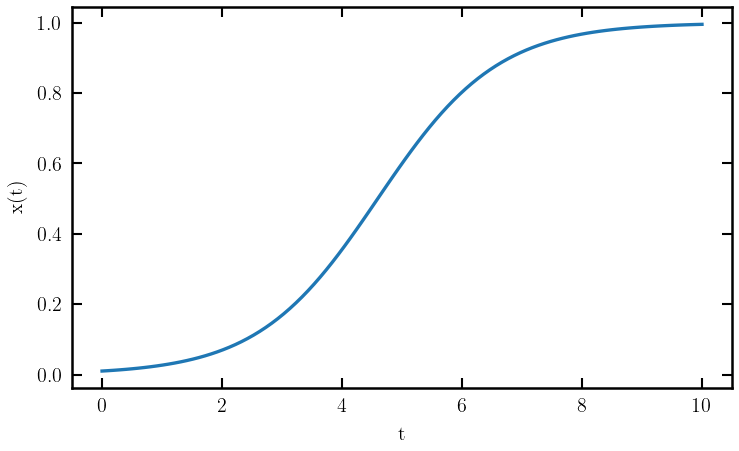

In [32]:
vf = lambda x: x*(1-x)
#exact solution:
x_exact = lambda t: 1 / (1 + (1 / 0.01 - 1) * np.exp(-t))


t0, t1 = 0.0, 10.0
N = 100
ts = np.linspace(t0, t1, num=N, endpoint=True)
t = np.linspace(t0, t1, 100, endpoint=True) #for visualization purpose exact solution
h = (t1 - t0) / N


plt.plot(t, x_exact(t), label='Exact Solution')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()

In [33]:
#initial value
y0 = 0.01
# initialize X(0) via the taylor coefficients
X_0 = np.array([y0, vf(y0), (1-y0)*(1-2*y0)*y0])

In [34]:
print(X_0[2]) 
print("this was manually computed, however in reality these taylor modes can be computed efficiently via autodiff:")
#autodiff of vf
vf_autodiff = jax.grad(vf)
print(vf(y0) * vf_autodiff(y0))

0.009702
this was manually computed, however in reality these taylor modes can be computed efficiently via autodiff:
0.009702


#### 1.1 Prior with correct Initialization

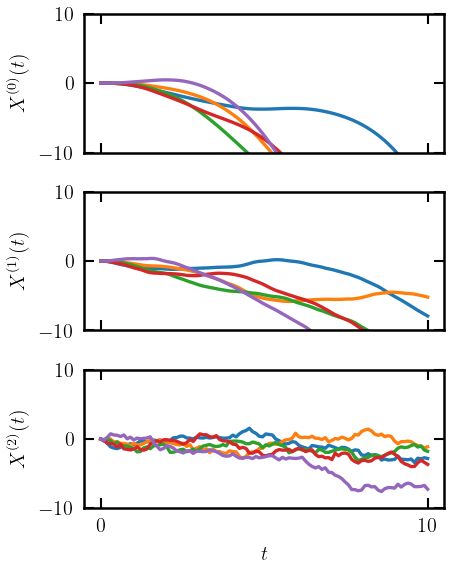

In [35]:
np.random.seed(42)

x1 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x2 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x3 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x4 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)
x5 = sample_IWP_path_from_taylor_modes(3, N, h, X_0)

# Create a 3x1 subplot for each component of x
fig, axs = plt.subplots(3, 1, figsize=(4, 5))

# Plot each component of x
for i in range(3):
    axs[i].plot(ts, x1[:, i])
    axs[i].plot(ts, x2[:, i])
    axs[i].plot(ts, x3[:, i])
    axs[i].plot(ts, x4[:, i])
    axs[i].plot(ts, x5[:, i])
    if i == 2:
        axs[i].set_xlabel('$t$')
        axs[i].set_xticks([0, 10])
    if i < 2:
        axs[i].set_xticks([0, 10])
        axs[i].set_xticklabels([])
    axs[i].set_ylabel(f'$X^{{({i})}}(t)$')
    axs[i].set_ylim(-10, 10)
    axs[i].set_yticks([-10, 0, 10])
#plt.savefig('2-times-IWP.png')

#### 1.2 Measurement Model

In [36]:
E_0 = np.array([[1,0,0]])
E_1 = np.array([[0,1,0]])
R = np.array([[0.22]])

g = lambda X: X[1] - vf(X[0])
jacobian_g = jacobian(g)

#### 1.3 Define Observed data

In [37]:
z_sequence = np.zeros(N)

In [38]:
N

100

In [39]:
print(h)
mu_0 = X_0
Sigma_0 = np.eye(3)*0

A_h = A(h)
Q_h = Q(h)
R_h = np.array([[0.1]])

print(mu_0.shape, Sigma_0.shape)
print(A_h.shape, Q_h.shape)


0.1
(3,) (3, 3)
(3, 3) (3, 3)


In [40]:
print(z_sequence.shape)
print(ts.shape)

(100,)
(100,)


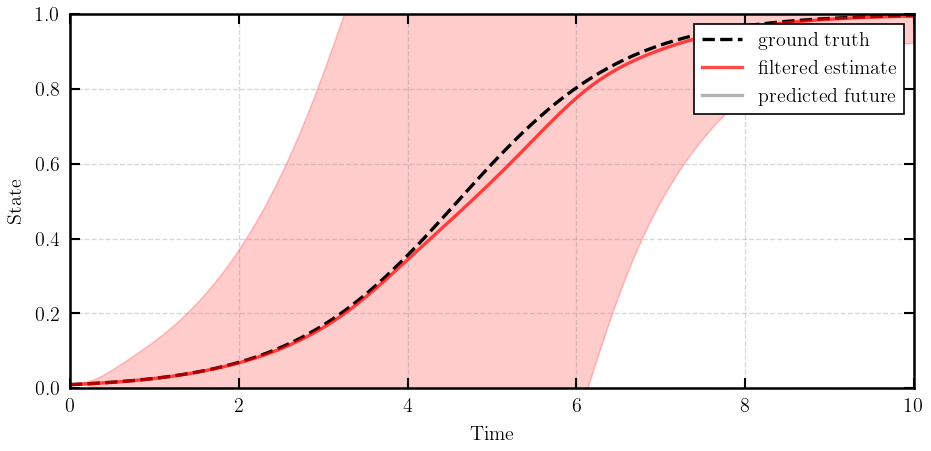

In [41]:
step = N-1
m_projected, P_projected, m_future_projected, P_future_projected = extended_kalman_filter(step, N, mu_0, Sigma_0, A_h, Q_h, R_h, z_sequence, g, jacobian_g)
plot_kalman_filter(step, ts, m_projected, P_projected, m_future_projected, P_future_projected, x_exact(ts), x_lim=[0,10], y_lim = [0,1])

In [16]:
ts.shape

(20,)